# 4-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [1]:
# 다운로드
# $ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# $ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# $ mv ratings_*.txt ~/aiffel/sentiment_classification

In [2]:
## 1. 데이터 준비 확인

In [3]:
import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/aiffel_exp4_movie/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_exp4_movie/sentiment_classification/ratings_test.txt')


train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성
## imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("ok")

ok


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()} 
print("ok")
# 위에 word_to_index아래에 썼을 땐 실행은 되지만 print로 출력해보면 안나옴

ok


In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]
print("ok")

ok


# 3) 모델구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
print(word_to_index["ㅋㅋㅋ"])     # '69' 가 출력됩니다. 
print(index_to_word[69])
print(len(word_to_index))
print(len(index_to_word))

69
ㅋㅋㅋ
10000
10000


In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [10]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# 패딩 추가

In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


In [13]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
라벨:  0
1번째 리뷰 문장 길이:  41
2번째 리뷰 문장 길이:  41


# 4) 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [14]:
# validation set 30000건 분리 train set의 약 20%
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 30000건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 5) 모델 훈련 개시

## RNN

In [15]:
# RNN 모델 구성
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

rnn_ver1_model = keras.Sequential()
rnn_ver1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_ver1_model.add(keras.layers.LSTM(8))
rnn_ver1_model.add(keras.layers.Dense(128, activation='relu'))
rnn_ver1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_ver1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 41,697
Trainable params: 41,697
Non-trainable params: 0
_________________________________________________________________


# 학습 개시

In [16]:
rnn_ver1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rnn_ver1_history = rnn_ver1_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

rnn_ver1_train_loss, rnn_ver1_train_accuracy = rnn_ver1_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(rnn_ver1_train_loss))
print("train_accuracy: {}".format(rnn_ver1_train_accuracy))

Epoch 1/5
227/227 [==============================] - 2s 7ms/step - loss: 0.5024 - accuracy: 0.7537 - val_loss: 0.3588 - val_accuracy: 0.8430
Epoch 2/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3405 - accuracy: 0.8546 - val_loss: 0.3465 - val_accuracy: 0.8500
Epoch 3/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3219 - accuracy: 0.8651 - val_loss: 0.3465 - val_accuracy: 0.8505
Epoch 4/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3121 - accuracy: 0.8694 - val_loss: 0.3499 - val_accuracy: 0.8489
Epoch 5/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3060 - accuracy: 0.8732 - val_loss: 0.3563 - val_accuracy: 0.8455
3631/3631 - 6s - loss: 0.2941 - accuracy: 0.8800
train_loss: 0.29408156871795654 
train_accuracy: 0.8800072073936462


In [17]:
# 테스트셋 평가
rnn_ver1_results = rnn_ver1_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_ver1_results)

1537/1537 - 2s - loss: 0.3667 - accuracy: 0.8413
[0.36671513319015503, 0.8412637114524841]


# 6) Loss, Accuracy 그래프 시각화

In [18]:
rnn_ver1_history_dict = rnn_ver1_history.history
print(rnn_ver1_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


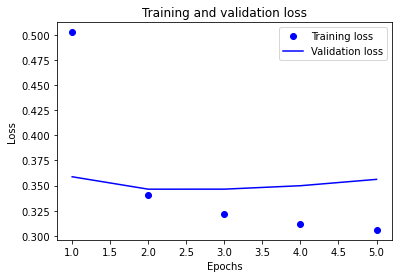

In [19]:
import matplotlib.pyplot as plt

acc = rnn_ver1_history_dict['accuracy']
val_acc = rnn_ver1_history_dict['val_accuracy']
loss = rnn_ver1_history_dict['loss']
val_loss = rnn_ver1_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

# 1-d Convolution Neural Network(1-D CNN)

In [20]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

cnn_ver1_model = keras.Sequential()
cnn_ver1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_ver1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_ver1_model.add(keras.layers.MaxPooling1D(5))
cnn_ver1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_ver1_model.add(keras.layers.GlobalMaxPooling1D())
cnn_ver1_model.add(keras.layers.Dense(8, activation='relu'))
cnn_ver1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_ver1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
cnn_ver1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_ver1_history = cnn_ver1_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

cnn_ver1_train_loss, cnn_ver1_train_accuracy = cnn_ver1_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(cnn_ver1_train_loss))
print("train_accuracy: {}".format(cnn_ver1_train_accuracy))

Epoch 1/5
227/227 [==============================] - 6s 28ms/step - loss: 0.5392 - accuracy: 0.7148 - val_loss: 0.3702 - val_accuracy: 0.8371
Epoch 2/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3457 - accuracy: 0.8510 - val_loss: 0.3484 - val_accuracy: 0.8496
Epoch 3/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3150 - accuracy: 0.8677 - val_loss: 0.3443 - val_accuracy: 0.8527
Epoch 4/5
227/227 [==============================] - 1s 4ms/step - loss: 0.2970 - accuracy: 0.8767 - val_loss: 0.3482 - val_accuracy: 0.8510
Epoch 5/5
227/227 [==============================] - 1s 4ms/step - loss: 0.2832 - accuracy: 0.8837 - val_loss: 0.3538 - val_accuracy: 0.8504
3631/3631 - 6s - loss: 0.2601 - accuracy: 0.8974
train_loss: 0.2600882649421692 
train_accuracy: 0.897359311580658


In [22]:
# 테스트셋 평가
cnn_ver1_results = cnn_ver1_model.evaluate(X_test,  y_test, verbose=2)

print(cnn_ver1_results)

1537/1537 - 4s - loss: 0.3658 - accuracy: 0.8440
[0.36583155393600464, 0.8440099954605103]


In [23]:
cnn_ver1_history_dict_1 = cnn_ver1_history.history
print(cnn_ver1_history_dict_1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


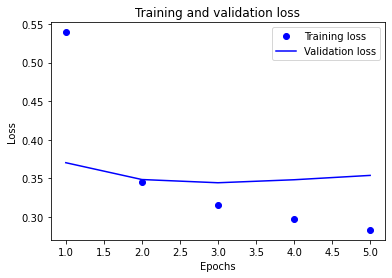

In [24]:
import matplotlib.pyplot as plt

acc = cnn_ver1_history_dict_1['accuracy']
val_acc = cnn_ver1_history_dict_1['val_accuracy']
loss = cnn_ver1_history_dict_1['loss']
val_loss = cnn_ver1_history_dict_1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

# GlobalMaxPooling1D 하나만 사용

In [25]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

gdp_ver1_model = keras.Sequential()
gdp_ver1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gdp_ver1_model.add(keras.layers.GlobalMaxPooling1D())
gdp_ver1_model.add(keras.layers.Dense(8, activation='relu'))
gdp_ver1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gdp_ver1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [26]:
gdp_ver1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gdp_ver1_history = gdp_ver1_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

gdp_ver1_train_loss, gdp_ver1_train_accuracy = gdp_ver1_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(gdp_ver1_train_loss))
print("train_accuracy: {}".format(gdp_ver1_train_accuracy))

Epoch 1/5
227/227 [==============================] - 1s 4ms/step - loss: 0.6577 - accuracy: 0.6978 - val_loss: 0.5884 - val_accuracy: 0.7513
Epoch 2/5
227/227 [==============================] - 1s 3ms/step - loss: 0.5079 - accuracy: 0.7818 - val_loss: 0.4482 - val_accuracy: 0.7995
Epoch 3/5
227/227 [==============================] - 1s 4ms/step - loss: 0.4194 - accuracy: 0.8163 - val_loss: 0.4075 - val_accuracy: 0.8169
Epoch 4/5
227/227 [==============================] - 1s 3ms/step - loss: 0.3846 - accuracy: 0.8333 - val_loss: 0.3933 - val_accuracy: 0.8225
Epoch 5/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3643 - accuracy: 0.8424 - val_loss: 0.3872 - val_accuracy: 0.8268
3631/3631 - 4s - loss: 0.3500 - accuracy: 0.8501
train_loss: 0.34998321533203125 
train_accuracy: 0.850105881690979


In [27]:
# 테스트셋 평가
gdp_ver1_results = gdp_ver1_model.evaluate(X_test,  y_test, verbose=2)

print(gdp_ver1_results)

1537/1537 - 2s - loss: 0.3965 - accuracy: 0.8228
[0.396529883146286, 0.8227922916412354]


In [28]:
gdp_ver1_history_dict_2 = gdp_ver1_history.history
print(gdp_ver1_history_dict_2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


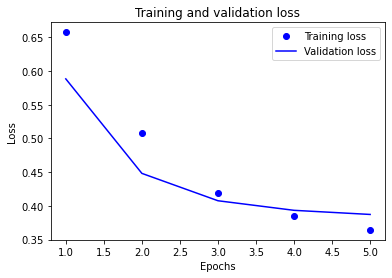

In [29]:
import matplotlib.pyplot as plt

acc = gdp_ver1_history_dict_2['accuracy']
val_acc = gdp_ver1_history_dict_2['val_accuracy']
loss = gdp_ver1_history_dict_2['loss']
val_loss = gdp_ver1_history_dict_2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

In [30]:
# 7) 학습된 Embedding 레이어 분석

In [31]:
# RNN

In [32]:
embedding_layer = rnn_ver1_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [33]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel_exp4_movie/sentiment_classification/1234word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_ver1_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['우주']
vector

array([ 0.04388485,  0.04325615, -0.06223876,  0.00230013], dtype=float32)

In [35]:
word_vectors.similar_by_word("우주")

[('관서', 0.9951021671295166),
 ('쯤', 0.9946135878562927),
 ('진지희', 0.9943133592605591),
 ('친한', 0.9941197633743286),
 ('쇼생크', 0.9934477806091309),
 ('노랑머리', 0.9932416081428528),
 ('장진', 0.9931413531303406),
 ('도데체', 0.9926652908325195),
 ('정신병', 0.9916306734085083),
 ('배드', 0.9913793802261353)]

In [36]:
# 1D-CNN

In [37]:
embedding_layer = cnn_ver1_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [38]:
import os


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel_exp4_movie/sentiment_classification/cnn_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cnn_ver1_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['우주']
vector

array([ 0.03398137, -0.00075969, -0.03964003, -0.04007489], dtype=float32)

In [40]:
word_vectors.similar_by_word("우주")

[('로우', 0.9997302293777466),
 ('사이트', 0.9987977147102356),
 ('문근영', 0.9987605810165405),
 ('할배', 0.9977378845214844),
 ('작자', 0.9962354302406311),
 ('장녀', 0.9955165386199951),
 ('명절', 0.994279146194458),
 ('화나', 0.9939761757850647),
 ('어필', 0.9935404062271118),
 ('즘', 0.9934496879577637)]

In [41]:
# GDP

In [42]:
embedding_layer = gdp_ver1_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [43]:
import os


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel_exp4_movie/sentiment_classification/gdp_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = gdp_ver1_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [44]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['우주']
vector

array([-0.00327938, -0.11557207, -0.07100914, -0.08437398], dtype=float32)

In [45]:
word_vectors.similar_by_word("우주")

[('로', 0.9994810223579407),
 ('이젠', 0.9994576573371887),
 ('건', 0.9993752837181091),
 ('류승범', 0.9993009567260742),
 ('애쓰', 0.999223530292511),
 ('합리', 0.9991393685340881),
 ('결말', 0.9989421367645264),
 ('이것', 0.9986511468887329),
 ('숨바꼭질', 0.9986134171485901),
 ('역겨운', 0.9984898567199707)]

In [46]:
# word2vec 임베딩 후

In [47]:
# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [48]:
import os
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/aiffel_exp4_movie/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path) # 블로그 보고 찾음
vector = word2vec['연예인']
vector     # 무려 300dim의 워드 벡터입니다.

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


array([ 0.0643605 , -0.75850713, -0.78850394,  0.21753669, -0.28130105,
       -0.6632435 ,  1.6914202 , -0.31084734, -0.64485806, -0.6700209 ,
        0.6235759 , -0.58446664, -1.1279049 , -0.03676866, -0.7908701 ,
        0.32665044,  0.7920674 ,  0.7052816 ,  0.23402977, -0.38289428,
        0.30356896, -0.55135953, -0.5923448 , -0.2642823 , -0.584332  ,
       -1.1653906 ,  0.70067364,  2.0277267 , -0.4266274 , -0.09212645,
        0.41646624, -1.3568132 , -0.30952153,  0.07049061, -0.16973379,
       -1.2042696 ,  1.3581532 ,  0.4709492 ,  0.43117502,  0.38722822,
       -0.21711977,  0.3697255 ,  0.73365796, -0.10968686, -1.0507535 ,
       -0.21823889,  1.1257955 , -0.25384673, -0.34050754,  0.3748362 ,
        0.2297252 , -0.64341813,  0.29639307,  0.18082614, -1.4727557 ,
       -0.7431612 ,  1.1861358 ,  0.9158351 ,  0.60654825,  0.4838607 ,
        1.0553918 , -0.43588084, -0.9833993 , -0.30019942,  0.29289278,
        0.23865221,  0.8824978 ,  0.33007935,  1.1195478 ,  1.93

In [49]:
similar = word2vec.wv.most_similar("행복", topn=8)
print(similar)
# word2vec.similar_by_word

[('사랑', 0.6759077310562134), ('기쁨', 0.6493781805038452), ('즐거움', 0.6396492719650269), ('삶', 0.629989743232727), ('젊음', 0.6187378764152527), ('즐겁', 0.6027448177337646), ('인생', 0.6002243161201477), ('존엄', 0.5952589511871338)]


In [50]:
similar = word2vec.wv.most_similar("우주", topn=8)
print(similar)

[('우주인', 0.5970311760902405), ('우주선', 0.5897793173789978), ('태양계', 0.5495188236236572), ('인공위성', 0.5380538105964661), ('발사체', 0.5338727831840515), ('생명체', 0.508995532989502), ('탐사선', 0.5014845132827759), ('외계', 0.49762028455734253)]


In [51]:
# 임베딩 레이어 word2vec으로 교체

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
print("ok")

ok


/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


---

# 5) 모델 훈련 개시

## RNN

In [53]:
from tensorflow.keras.initializers import Constant
print("ok")

ok


In [54]:
# RNN 모델 구성


vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어) 
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
# 아래 오류로 vocab_size 수정
# TypeError: Eager execution of tf.constant with unsupported shape (value has 2000000 elements, shape is (10000, 16) with 160000 elements).


rnn_ver2_model = keras.Sequential()
rnn_ver2_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_shape=(None,)))
rnn_ver2_model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
rnn_ver2_model.add(keras.layers.Dense(8, activation='relu'))
rnn_ver2_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_ver2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


# 학습 개시

In [57]:
rnn_ver2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_ver2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

rnn_ver2_train_loss, rnn_ver2_train_accuracy = rnn_ver2_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(rnn_ver2_train_loss))
print("train_accuracy: {}".format(rnn_ver2_train_accuracy))

Epoch 1/4
227/227 [==============================] - 7s 33ms/step - loss: 0.1371 - accuracy: 0.9487 - val_loss: 0.4089 - val_accuracy: 0.8609
Epoch 2/4
227/227 [==============================] - 7s 32ms/step - loss: 0.1100 - accuracy: 0.9603 - val_loss: 0.4626 - val_accuracy: 0.8605
Epoch 3/4
227/227 [==============================] - 7s 32ms/step - loss: 0.0938 - accuracy: 0.9664 - val_loss: 0.5076 - val_accuracy: 0.8568
Epoch 4/4
227/227 [==============================] - 7s 32ms/step - loss: 0.0792 - accuracy: 0.9719 - val_loss: 0.5459 - val_accuracy: 0.8551
3631/3631 - 7s - loss: 0.0608 - accuracy: 0.9797
train_loss: 0.06083481386303902 
train_accuracy: 0.979661226272583


In [58]:
# 테스트셋 평가
rnn_ver2_results = rnn_ver2_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_ver2_results)

1537/1537 - 3s - loss: 0.5487 - accuracy: 0.8534
[0.5487379431724548, 0.8534084558486938]


In [59]:
rnn_ver2_history_dict_3 = history.history
print(rnn_ver2_history_dict_3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


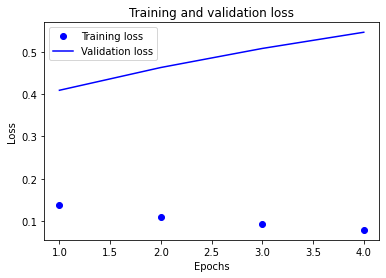

In [60]:
import matplotlib.pyplot as plt

acc = rnn_ver2_history_dict_3['accuracy']
val_acc = rnn_ver2_history_dict_3['val_accuracy']
loss = rnn_ver2_history_dict_3['loss']
val_loss = rnn_ver2_history_dict_3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

In [ ]:
# 그래프로 확인해보니 epochs가 4이면 될 것 같음

# 1-d Convolution Neural Network(1-D CNN)

In [61]:
vocab_size = 100000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

cnn_ver2_model = keras.Sequential()
cnn_ver2_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_shape=(None,)))
cnn_ver2_model.add(keras.layers.Conv1D(32, 7, activation='relu'))
cnn_ver2_model.add(keras.layers.MaxPooling1D(5))
cnn_ver2_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
cnn_ver2_model.add(keras.layers.GlobalMaxPooling1D())
cnn_ver2_model.add(keras.layers.Dense(8, activation='relu'))
cnn_ver2_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_ver2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 20)          2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          4512      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          14400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [62]:
cnn_ver2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_ver2_history = cnn_ver2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

cnn_ver2_train_loss, cnn_ver2_train_accuracy = cnn_ver2_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(cnn_ver2_train_loss))
print("train_accuracy: {}".format(cnn_ver2_train_accuracy))

Epoch 1/4
227/227 [==============================] - 12s 51ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/4
227/227 [==============================] - 4s 16ms/step - loss: 0.6926 - accuracy: 0.5044 - val_loss: 0.6822 - val_accuracy: 0.5722
Epoch 3/4
227/227 [==============================] - 4s 19ms/step - loss: 0.5385 - accuracy: 0.7232 - val_loss: 0.4603 - val_accuracy: 0.7793
Epoch 4/4
227/227 [==============================] - 4s 17ms/step - loss: 0.4282 - accuracy: 0.8005 - val_loss: 0.4198 - val_accuracy: 0.8062
3631/3631 - 7s - loss: 0.3962 - accuracy: 0.8204
train_loss: 0.3961549401283264 
train_accuracy: 0.8204024434089661


In [63]:
# 테스트셋 평가
cnn_ver2_results = cnn_ver2_model.evaluate(X_test,  y_test, verbose=2)

print(cnn_ver2_results)

1537/1537 - 4s - loss: 0.4294 - accuracy: 0.8005
[0.4293554425239563, 0.8005167245864868]


In [64]:
cnn_ver2_history_dict_4 = history.history
print(cnn_ver2_history_dict_4.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


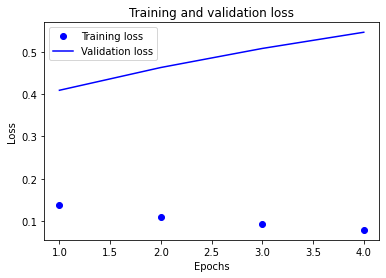

In [65]:
import matplotlib.pyplot as plt

acc = cnn_ver2_history_dict_4['accuracy']
val_acc = cnn_ver2_history_dict_4['val_accuracy']
loss = cnn_ver2_history_dict_4['loss']
val_loss = cnn_ver2_history_dict_4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

In [ ]:
# 그래프로 확인해보면 epochs 4 ~ 5이면 될 것 같음

# GlobalMaxPooling1D 하나만 사용

In [70]:
vocab_size = 100000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

gdp_ver2_model = keras.Sequential()
gdp_ver2_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_shape=(None,)))
gdp_ver2_model.add(keras.layers.GlobalMaxPooling1D())
gdp_ver2_model.add(keras.layers.Dense(8, activation='relu'))
gdp_ver2_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gdp_ver2_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 20)          2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 168       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,000,177
Trainable params: 2,000,177
Non-trainable params: 0
_________________________________________________________________


In [71]:
gdp_ver2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gdp_ver2_history = gdp_ver2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

gdp_ver2_train_loss, gdp_ver2_train_accuracy = gdp_ver2_model.evaluate(partial_X_train, partial_y_train, verbose=2)

print("train_loss: {} ".format(gdp_ver2_train_loss))
print("train_accuracy: {}".format(gdp_ver2_train_accuracy))

Epoch 1/4
227/227 [==============================] - 4s 18ms/step - loss: 0.6914 - accuracy: 0.5454 - val_loss: 0.6783 - val_accuracy: 0.5644
Epoch 2/4
227/227 [==============================] - 4s 18ms/step - loss: 0.6576 - accuracy: 0.6057 - val_loss: 0.6399 - val_accuracy: 0.6301
Epoch 3/4
227/227 [==============================] - 4s 18ms/step - loss: 0.6097 - accuracy: 0.6634 - val_loss: 0.5912 - val_accuracy: 0.6827
Epoch 4/4
227/227 [==============================] - 4s 18ms/step - loss: 0.5618 - accuracy: 0.7062 - val_loss: 0.5511 - val_accuracy: 0.7150
3631/3631 - 5s - loss: 0.5403 - accuracy: 0.7257
train_loss: 0.5402933359146118 
train_accuracy: 0.7257234454154968


In [73]:
# 테스트셋 평가
gdp_ver2_results = gdp_ver2_model.evaluate(X_test,  y_test, verbose=2)

print(gdp_ver2_results)

1537/1537 - 2s - loss: 0.5506 - accuracy: 0.7169
[0.5505526661872864, 0.7168663740158081]


In [75]:
gdp_ver2_history_dict_5 = gdp_ver2_history.history
print(gdp_ver2_history_dict_5.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


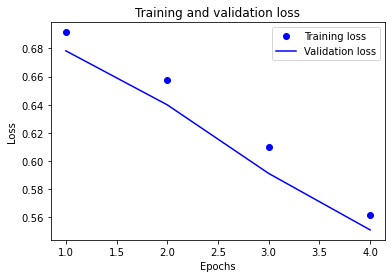

In [76]:
import matplotlib.pyplot as plt

acc = gdp_ver2_history_dict_5['accuracy']
val_acc = gdp_ver2_history_dict_5['val_accuracy']
loss = gdp_ver2_history_dict_5['loss']
val_loss = gdp_ver2_history_dict_5['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# validation loss와 train loss와 이격이 발생하면 더 이상의 트레이닝은 무의미

In [ ]:
# 그래프로 확인해보니 epochs가 7~8이면 될 것 같음

# 총평

1. 소감  
이번 자연어 exploration은 재밌었다.  
하지만 데이터 로더 구성하라고 할 때 좀 멘붕이었다.  
이전 노드들을 참고하면서 데이터로더 부분에 대한 내용이 없길래  
이걸 어떻게 구현해야할지 막막했다.   
일단 필요한 것을 찾아서 여러 개의 블로그를 참고 했지만 원하는 것을 얻지 못했다..  
그래서 3\~4일동안 진짜 멘붕이었는데 노드를 계속 바라보니 **"예시 답안"** 이 보였다.   
그땐 왜 이걸 이제 봤을까 생각했지만 그래도 앞으로 해결할 수 있겠다라는 생각에 좋았다..  
데이터로더 부분을 해결한 이후에도 중간중간 어려운 부분들도 있었지만  
서로 안되는 부분을 조원들과 공유하여 해결했고  
조원들과 같이 고민해도 해결안되던 부분을 마지막엔 영석퍼실님이 도와주셔서 해결할 수 있었다.  
영석퍼실님 감사합니다~

2. 느낀점  
이번 exploration을 하면서 아직도 내가 뭘 할 수 있겠다는 생각은 전혀 들지 않는다.
그런데 조금 달라진 것은 나는 여태 복사 붙여넣기만 했을 뿐인데 노드를 진행하면서 생각?을 조금 할 수 있게 된 것 같다.
무슨 뜻이냐면....  
종종 어떤 오류가 발생하거나 해결 해야할 때 "이거 복사하면 될 것 같은데, 이게 문제인 것 같은데" 얕게라도? 조금은 생각할 수 있게 된 것 같다.  
개인적으론 2주 전보다 더 나아진 것 같아 좋다.

3. 루브릭 평가
- rnn, cnn, gdp 모두 모델 구성 후 작동
- word2vec 임베딩 후 성능 개선
    - word2vec 입력 전에는 연관성이 없는 유사 단어들도 있었지만 임베딩 후에는 꽤 유사한 단어들이 많이 나왔다.
- rnn모뎅를 통해 아주 근소한 차이로 0.85 달성
    - 이미 exp4에 시간을 너무 많이써서 추가로 해볼 순 없었지만 계속 만지다 보면 조금 더 올라갈 수 있을 것 같다.